In [1]:
# Import helper libraries
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import
from future import standard_library
standard_library.install_aliases()  # NOQA
import argparse
import logging
import sys

#__________________________________________________________________________________________________________________________________________________________________________

# Import scientific libraries

import numpy as np               # Numpy, a good library to deal with matrices in python.
import matplotlib.pyplot as plt  # Matplotlib, a good library for plotting in python.
from matplotlib import style
#__________________________________________________________________________________________________________________________________________________________________________

import gym                       # Gym, a collection of RL environemnts.
gym.undo_logger_setup()  # NOQA
from gym import spaces  
import gym.wrappers

from osim.env import ProstheticsEnv   # Open simulator (OSIM), an open source simnulation for biomechanical modeling.

#__________________________________________________________________________________________________________________________________________________________________________


import chainer                               # Chainer, a python-based deep learning framework. Chainerrl, a reinforcement learning library based on chainer framework.
from chainer import optimizers               # a collection of Neural Network optimizers.
from chainerrl.agents.ddpg import DDPG       # a DDPG agent
from chainerrl.agents.ddpg import DDPGModel  # a DDPG model, responsibles to combine the policy network and the value function network.
from chainerrl import explorers              # a collection of explores functions.
from chainerrl import misc                   # a collection of utility functions to manipulate the environemnts.
from chainerrl import policy                 # a policy network
from chainerrl import q_functions            # a value function network
from chainerrl import replay_buffer          # a Replay buffer to store a set of observations for the DDPG agent.

style.use('ggplot')

/home/waleed_daud_wd/CondaEnvs/opensimEnv_V2/lib/python3.6/site-packages/gym/__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")


In [2]:
# Chainer's settings
seed=0
gpu=0   # a GPU device id

# Hyperparameters for Policy and Value function Networks

In [1]:
# Hyperparameters: 1


# Policy Network ( Actor ).

actor_hidden_layers=3                        # Number of hidden layers.
actor_hidden_units=300                       # Number of hidden units
actor_lr=1e-4                                # learning rate

# Value function Network ( Critic )
critic_hidden_layers=3                       # Number of hidden layers.
critic_hidden_units=300                      # Number of hidden units
critic_lr=1e-3                               # learning rate.

In [4]:
# Hyperparameters: 2

number_of_episodes=2000                     # Number of episodes
max_episode_length=1000                     # Max length of the episode.

replay_buffer_size=5 * 10 ** 5              # the size of the replay buffer.
replay_start_size=5000                      # the size of the replay buffer when the network starts the training step.
number_of_update_times=1                    # Number of repetition of update.

target_update_interval=1                    # Target update interval in each step.
target_update_method='soft'                 # the type of update: hard or soft.

soft_update_tau=1e-2                        # The value of Tau  in the soft target update.
update_interval=4                           # Model update interval in eac step.
number_of_eval_runs=100
# eval_interval=10 ** 5

# final_exploration_steps=10 ** 6            

gamma=0.995                               # Discount factor
minibatch_size=128                        # Batch size


# A set of helper functions 

In [5]:
# Helper's functions

def clip_action_filter(a):
    """ limit the an action value between the higest and lowest values in action space.
    Input: a
    Output: clipped action
    """
    return np.clip(a, action_space.low, action_space.high)

def reward_filter(r):
    """ Scale the reward value.
    Input: reward (r)
    Output: scaled reward
    """
    return r *1 #1e-2


def phi(obs):
    """ Convert the data type of the observation to float-32
    Input: observation (obs)
    Output:  the processed observation 
    """ 
    obs=np.array(obs)
    return obs.astype(np.float32)


def random_action():
    """ Generate a random action.
    Input: None
    Output:  a random action
    """ 
    a = action_space.sample()
    if isinstance(a, np.ndarray):
        a = a.astype(np.float32)
    return a


def make_env(test,render=False):
    
    """ Create an instance from "ProstheticEnv" environment
    Input: a boolean value to show if it's an agent training experiment or test experiment (test)
    Output:  "ProstheticEnv" environment (env)
    """ 
        
    env = ProstheticsEnv(visualize=render)
    # Use different random seeds for train and test envs
    env_seed = 2 ** 32 - 1 - seed if test else seed
    env.seed(env_seed)
    #if args.monitor:
        #env = gym.wrappers.Monitor(env, args.outdir)
    if isinstance(env.action_space, spaces.Box):
        misc.env_modifiers.make_action_filtered(env, clip_action_filter)
    if not test:
        misc.env_modifiers.make_reward_filtered(env, reward_filter)
    if render and not test:
        misc.env_modifiers.make_rendered(env)
    return env

In [6]:
# Set a random seed used in ChainerRL
misc.set_random_seed(seed)

In [7]:
# Setup the environment
env = make_env(test=False,render=False)
obs_size = np.asarray(env.observation_space.shape).prod()
action_space = env.action_space

action_size = np.asarray(action_space.shape).prod()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Could not seed environment <ProstheticsEnv<0>>


# Initialize the "Actor" and "Value function" Networks.

In [8]:
# Critic Network

q_func = q_functions.FCSAQFunction(
            obs_size, 
            action_size,
            n_hidden_channels=critic_hidden_units,
            n_hidden_layers=critic_hidden_layers)

# Policy Network

pi = policy.FCDeterministicPolicy(
            obs_size, 
            action_size=action_size,
            n_hidden_channels=actor_hidden_units,
            n_hidden_layers=actor_hidden_layers,
            min_action=action_space.low, 
            max_action=action_space.high,
            bound_action=True)


# Building the "DDPG" agent

In [9]:
# The Model

model = DDPGModel(q_func=q_func, policy=pi)
opt_actor = optimizers.Adam(alpha=actor_lr)
opt_critic = optimizers.Adam(alpha=critic_lr)
opt_actor.setup(model['policy'])
opt_critic.setup(model['q_function'])
opt_actor.add_hook(chainer.optimizer.GradientClipping(1.0), 'hook_a')
opt_critic.add_hook(chainer.optimizer.GradientClipping(1.0), 'hook_c')

rbuf = replay_buffer.ReplayBuffer(replay_buffer_size)
ou_sigma = (action_space.high - action_space.low) * 0.2

explorer = explorers.AdditiveOU(sigma=ou_sigma)

In [10]:
# The agent
agent = DDPG(model, opt_actor, opt_critic, rbuf, gamma=gamma,
                 explorer=explorer, replay_start_size=replay_start_size,
                 target_update_method=target_update_method,
                 target_update_interval=target_update_interval,
                 update_interval=update_interval,
                 soft_update_tau=soft_update_tau,
                 n_times_update=number_of_update_times,
                 phi=phi,minibatch_size=minibatch_size
            )

# Training step

In [ ]:
G=[]
G_mean=[]
for ep in range(1, number_of_episodes+ 1):
    
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    episode_rewards=[]
    while not done and t < max_episode_length:
        env.render()
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        episode_rewards.append(reward)
        t += 1
        
    if done or t > max_episode_length:
            
        # Calculate sum of the rewards
        episode_rewards_sum = sum(episode_rewards)     
        G.append(episode_rewards_sum)
        total_G = np.sum(G)
        maximumReturn = np.amax(G)
        if ep % 1 == 0:
                
            print("==========================================")
            print("Episode: ", ep)
            print("Rewards: ", episode_rewards_sum)
            print("Max reward so far: ", maximumReturn)
            # Mean reward
            total_reward_mean = np.divide(total_G, ep+1)
            G_mean.append(total_reward_mean)
            print("Mean Reward", total_reward_mean)
            
    # Save the model every 100 episode.       
    if ep%100==0:
        agent.save("DDPG_Prosthetic_model")
                
                
    agent.stop_episode_and_train(obs, reward, done)
    
    
print('Finished.')

Episode:  1
Rewards:  -501.1440388875725
Max reward so far:  -501.1440388875725
Mean Reward -250.57201944378625
Episode:  2
Rewards:  -544.2430105998064
Max reward so far:  -501.1440388875725
Mean Reward -348.46234982912637
Episode:  3
Rewards:  -472.14548842926337
Max reward so far:  -472.14548842926337
Mean Reward -379.3831344791606
Episode:  4
Rewards:  -555.3695883637976
Max reward so far:  -472.14548842926337
Mean Reward -414.580425256088
Episode:  5
Rewards:  -560.8013319627033
Max reward so far:  -472.14548842926337
Mean Reward -438.95057637385725
Episode:  6
Rewards:  -168.0932536428566
Max reward so far:  -168.0932536428566
Mean Reward -400.25667312657146
Episode:  7
Rewards:  -539.3583417841828
Max reward so far:  -168.0932536428566
Mean Reward -417.64438170877287
Episode:  8
Rewards:  -458.98476535058575
Max reward so far:  -168.0932536428566
Mean Reward -422.23775766897427
Episode:  9
Rewards:  -442.90213049424676
Max reward so far:  -168.0932536428566
Mean Reward -424.3041

In [15]:
# Save the model.
agent.save("DDPG_Prosthetic_model")

## Plotting

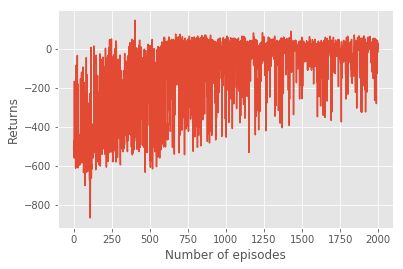

In [19]:
plt.plot(G)
plt.ylabel('Returns')
plt.xlabel('Number of episodes')
plt.savefig("DDPG_Prosthetic_Episodes_VS_Returns.png")

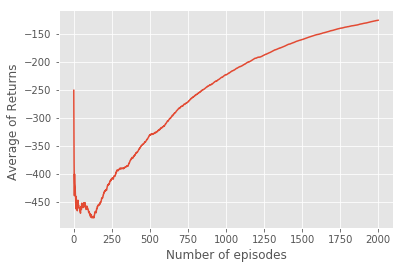

In [20]:
plt.plot(G_mean)
plt.ylabel('Average of Returns ')
plt.xlabel('Number of episodes')
plt.savefig("DDPG_Prosthetic_AverageEpisodes_VS_Returns.png")